# CanESM5 GMD paper Figure 16&17
## Ocean temperature, salinity and MOC section.

### history
- NCS, setup basic example, 2019-03-28

In [ ]:
import xarray as xr
import numpy as np
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import iris
import iris.analysis.cartography
import modules.basic_stats as bst
import modules.plotting_module as pltm
import sqlite3

from cdo import *
cdo = Cdo()
cdo.setCdo('/home/ords/crd/ccrn/scrd104/miniconda3/bin/cdo')

In [2]:
%store -r start 
%store -r end
%store -r title_fontsize
%store -r zeroC_in_K

In [3]:
#mask CanESM2 data and save before remapping 
mask_and_create_netcdf = False

if mask_and_create_netcdf:
    sftof = xr.open_dataset('input_data/CanESM2_small_ensemble/fx/ocean/sftof/r0i0p0/sftof_fx_CanESM2_historical_r0i0p0.nc')
    thetao = xr.open_mfdataset('input_data/CanESM2_large_ensemble/historical-r1/mon/ocean/thetao/r1i1p1/thetao_Omon_CanESM2_historical-r1_r1i1p1_*.nc').sel(time=slice(start,end))
    so = xr.open_mfdataset('input_data/CanESM2_large_ensemble/historical-r1/mon/ocean/so/r1i1p1/so_Omon_CanESM2_historical-r1_r1i1p1_*.nc').sel(time=slice(start,end))

    thetao = pltm.replace_dim(thetao, 'lat', sftof['lat'])
    thetao = pltm.replace_dim(thetao, 'lon', sftof['lon'])

    so = pltm.replace_dim(so, 'lat', sftof['lat'])
    so = pltm.replace_dim(so, 'lon', sftof['lon'])

    merged = xr.merge([sftof['sftof'],thetao['thetao']])
    masked = merged.where(merged.sftof>=100)
    masked = masked.where(merged.thetao > 0) #remove absolute zeros
    masked.to_netcdf(path='input_data/processed_data/masked_thetao_Omon_CanESM2_historical_r1i1p1_198101-201012.nc')

    merged1 = xr.merge([sftof['sftof'],so['so']])
    masked1 = merged1.where(merged1.sftof>=100)
    masked1 = masked1.where(merged1.so > 0)
    masked1.to_netcdf(path='input_data/processed_data/masked_so_Omon_CanESM2_historical_r1i1p1_198101-201012.nc')


In [4]:
# regrid
regrid=False

if regrid:
    thetao_obs = xr.open_dataset('input_data/obs/woa/woa09/uncs_woa09_ann_tpot.nc', decode_times=False)['tpot']
    woa09_depths = [str(f) for f in thetao_obs.depth.values]
    
    #CanESM2
    datapath='input_data/processed_data/'
    filelist=['masked_{var}_Omon_CanESM2_historical_r1i1p1_198101-201012.nc']
    
    varlist=['thetao', 
             'so']
            
    for var in varlist:
        filestr=' '.join([datapath.format(var=var) + f.format(var=var) for f in filelist])
        cdo.intlevelx(','.join(woa09_depths), 
                     input='-remapbil,obs/woa/woa09/uncs_woa09_ann_tpot.nc ' + filestr, 
                     output='input_data/processed_data/remap_vertint-woa09_' + var +  '_Omon_CanESM2_historical-r1_r1i1p1_198101-201012.nc', options='-L')
 
    
    #CanESM5
    datapath='input_data/CanESM5_cmip_dir/historical/r1i1p1f1/Omon/{var}/gn/v20190429/'
    filelist=['{var}_Omon_CanESM5_historical_r1i1p1f1_gn_198101-199012.nc', 
              '{var}_Omon_CanESM5_historical_r1i1p1f1_gn_199101-200012.nc', 
              '{var}_Omon_CanESM5_historical_r1i1p1f1_gn_200101-201012.nc']
    
    varlist=['thetao', 
             'so']
            
    for var in varlist:
        filestr=' '.join([datapath.format(var=var) + f.format(var=var) for f in filelist])
        cdo.intlevelx(','.join(woa09_depths), 
                     input='-remapbil,obs/woa/woa09/uncs_woa09_ann_tpot.nc -mergetime ' + filestr, 
                     output='input_data/processed_data/remap_vertint-woa09_' + var +  '_Omon_CanESM5_historical_r1i1p1f1_gn_198101-201012.nc', options='-L')
 

In [5]:
mask = xr.open_dataset('input_data/processed_data/remap_vertint-woa09_thetao_Omon_CanESM5_historical_r1i1p1f1_gn_200101-201012.nc')['thetao']
mask2 = mask[0,...].sel(lev=10).where( (mask.lat>40) & (mask.lat<47) & (mask.lon>25) & (mask.lon<45))

thetao = xr.open_dataset('input_data/processed_data/remap_vertint-woa09_thetao_Omon_CanESM5_historical_r1i1p1f1_gn_198101-201012.nc')['thetao'].squeeze().where( np.isnan(mask2), np.nan)
so = xr.open_dataset('input_data/processed_data/remap_vertint-woa09_so_Omon_CanESM5_historical_r1i1p1f1_gn_198101-201012.nc')['so'].squeeze().where( np.isnan(mask2), np.nan)

thetao_CanESM2 = xr.open_dataset('input_data/processed_data/remap_vertint-woa09_thetao_Omon_CanESM2_historical-r1_r1i1p1_198101-201012.nc')['thetao'].squeeze().where( np.isnan(mask2), np.nan)-zeroC_in_K
so_CanESM2 = xr.open_dataset('input_data/processed_data/remap_vertint-woa09_so_Omon_CanESM2_historical-r1_r1i1p1_198101-201012.nc')['so'].squeeze().where( np.isnan(mask2), np.nan)

thetao_obs = xr.open_dataset('input_data/obs/woa/woa09/uncs_woa09_ann_tpot.nc', decode_times=False)['tpot'].rename( {'depth':'lev'}).squeeze().where( np.isnan(mask2), np.nan)
so_obs = xr.open_dataset('input_data/obs/woa/woa09/salinity_annual_1deg.nc', decode_times=False)['s_an'].rename( {'depth':'lev'}).squeeze().where( np.isnan(mask2), np.nan)

In [6]:
thetao_zm = thetao.mean(dim=['time','lon'])
thetao_obs_zm = thetao_obs.mean(dim='lon')
so_zm = so.mean(dim=['time','lon'])
so_obs_zm = so_obs.mean(dim='lon')

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, '(d)')

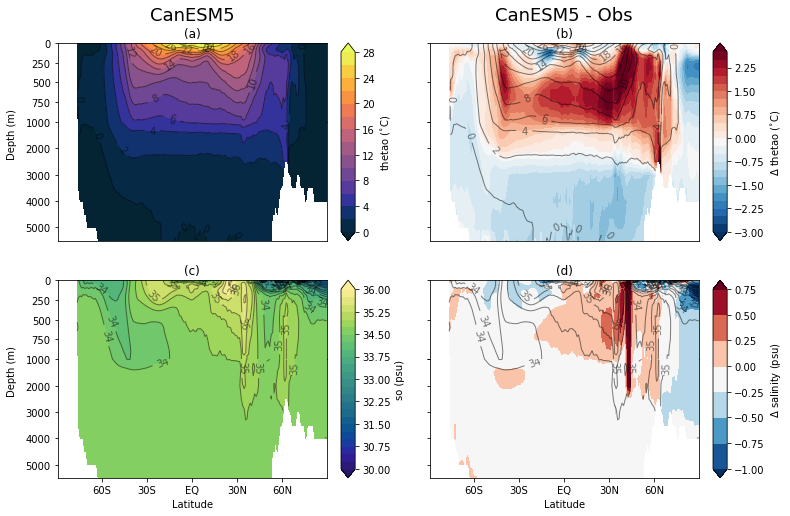

In [17]:
fig = plt.figure(figsize=(12, 8), constrained_layout=False)
outer_grid = fig.add_gridspec(2, 2, wspace=0.25, hspace=0.2)

# plot the thetao
axt, axm, axc = pltm.inner_gs_vardepth(outer_grid[0], labely=True, labelx=False)
cmap=cmocean.cm.thermal
cmap.set_bad(cfeature.COLORS['land'])
levelst = np.arange(0,30,2)
for ax in [axt, axm]:
    cb  = ax.contourf(thetao.lat, thetao.lev, thetao_zm, cmap=cmap, levels=levelst,extend='both')
    cntr = ax.contour(thetao.lat, thetao.lev, thetao_zm, levels=levelst, colors='k', linewidths=1, alpha=0.5)
    ax.clabel(cntr,fmt='%1.0f')
plt.colorbar(cb, cax=axc, extend='both', label =r'thetao ($^{\circ}$C)')
axt.set_title('(a)')
axt.text(0.5, 1.35, 'CanESM5', horizontalalignment='center', verticalalignment='center', fontsize=title_fontsize, transform=axt.transAxes)
 

# plot the so
axt, axm, axc = pltm.inner_gs_vardepth(outer_grid[2], labely=True, labelx=True)
cmap=cmocean.cm.haline
cmap.set_bad(cfeature.COLORS['land'])
levelss = np.arange(30,36.2,0.25)
for ax in [axt, axm]:
    cb  = ax.contourf(so.lat, so.lev, so_zm, cmap=cmap, levels=levelss,extend='both')
    cntr = ax.contour(so.lat, so.lev, so_zm, levels=levelss, colors='k', linewidths=1, alpha=0.5)
    ax.clabel(cntr,fmt='%1.0f')
plt.colorbar(cb, cax=axc, extend='both', label =r'so (psu)')
axt.set_title('(c)')


# plot the thetao Anomaly
cmap=plt.cm.RdBu_r
cmap.set_bad(cfeature.COLORS['land'])
axt, axm, axc = pltm.inner_gs_vardepth(outer_grid[1], labely=False)
levels = np.arange(-3,3,0.25)
for ax in [axt, axm]:
    cb  = ax.contourf(thetao.lat, thetao.lev, thetao_zm - thetao_obs_zm, cmap=cmap, levels=levels,extend='both')
    cntr = ax.contour(thetao.lat, thetao.lev, thetao_zm, levels=levelst, colors='k', linewidths=1, alpha=0.5)
    ax.clabel(cntr,fmt='%1.0f')
plt.colorbar(cb, cax=axc, extend='both', label='$\Delta$ thetao ($^{\circ}$C)')
axt.set_title('(b)')
axt.text(0.5, 1.35, 'CanESM5 - Obs', horizontalalignment='center', verticalalignment='center', fontsize=title_fontsize, transform=axt.transAxes)


# plot the so Anomaly
axt, axm, axc = pltm.inner_gs_vardepth(outer_grid[3], labely=False, labelx=True)
levels = np.arange(-1,1,0.25)
for ax in [axt, axm]:
    cb  = ax.contourf(so.lat, so.lev, so_zm - so_obs_zm, cmap=cmap, levels=levels,extend='both')
    cntr = ax.contour(so.lat, so.lev, so_zm, levels=levelss, colors='k', linewidths=1, alpha=0.5)
    ax.clabel(cntr,fmt='%1.0f')
plt.colorbar(cb, cax=axc, extend='both', label =r'$\Delta$ salinity (psu)')
axt.set_title('(d)')

fig.savefig('plots/fig-16_ocean_t-s.png', bbox_inches='tight')
fig.savefig('plots/fig-16_ocean_t-s.pdf', bbox_inches='tight')

In [ ]:
##### statistics - for zonal means
xyzt = 'FTTF'
av_dims = ['time','lon'] #dimensions over which to average (time for global time means, time and lon for zonal means and sections, )
weight =  np.tile(thetao_zm.lev,(180,1)).transpose()
calc_skill_score = False

#the following lists will be zipped for the stats calcs, so all info should be entered accordingly
model_names    = ['CanESM5','CanESM5']  
model_datasets    = [thetao_zm,so_zm]
model_fulldatasets = [None,None]

obs_names    = ['woa09','woa09']
obs_datasets    = [thetao_obs_zm,so_obs_zm]
obs_fulldatasets = [None,None]

stats_names = ['thetao_zonal_timemean','so_zonal_timemean'] #names for json file
varslist = ['thetao','so']


bst.calc_stats_and_write(obs_datasets, obs_fulldatasets, obs_names, model_datasets, model_fulldatasets, model_names, stats_names, varslist, weight, xyzt, av_dims,
                         start, end, calc_skill_score=calc_skill_score)

In [ ]:
##### statistics - for full 3D timemeans

#weights
levs = thetao.lev.diff('lev',n=1).values
levs = np.insert(levs, 0, 10, axis=0)
lev_weights = np.tile(np.tile(levs,(180,1)),(360,1,1))

gridcellareas =  xr.open_dataset('input_data/obs/woa/woa09_gridarea.nc')['cell_area'].values
gridcellaarea_weights = np.tile(gridcellareas,(len(levs),1,1))
gridcellaarea_weights_t = gridcellaarea_weights.transpose()

gridvolume_weights = lev_weights*gridcellaarea_weights_t


xyzt = 'TTTF'
av_dims = ['time'] #dimensions over which to average (time for global time means, time and lon for zonal means and sections)
weight = gridvolume_weights
calc_skill_score = False

#the following lists will be zipped for the stats calcs, so all info should be entered accordingly
model_names    = ['CanESM5','CanESM5',
                  'CanESM2','CanESM2']
model_datasets    = [thetao.mean('time'),so.mean('time'),
                     thetao_CanESM2.mean('time'),so_CanESM2.mean('time')]
model_fulldatasets = [thetao, so,
                      thetao_CanESM2,so_CanESM2]
 
obs_names    = ['woa09','woa09',
                'woa09','woa09']
obs_datasets    = [thetao_obs, so_obs, 
                   thetao_obs, so_obs]
obs_fulldatasets = [None,None,None,None]

stats_names = ['thetao_3D_timemean','so_3D_timemean',
               'thetao_3D_timemean_CanESM2','so_3D_timemean_CanESM2'] #names for json file
varslist = ['thetao','so',
            'thetao','so']


bst.calc_stats_and_write(obs_datasets, obs_fulldatasets, obs_names, model_datasets, model_fulldatasets, model_names, stats_names, varslist, weight, xyzt, av_dims, 
                         start, end, calc_skill_score=calc_skill_score, use_model_std=True, annual_data=False)

In [7]:
moc=xr.open_dataset('input_data/CanESM5_cmip_dir/historical/r1i1p1f1/Omon/msftmz/gn/v20190429/msftmz_Omon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc')['msftmz'].sel(time=slice(start, end))
mocm = moc.mean(dim='time')/1035./1e6

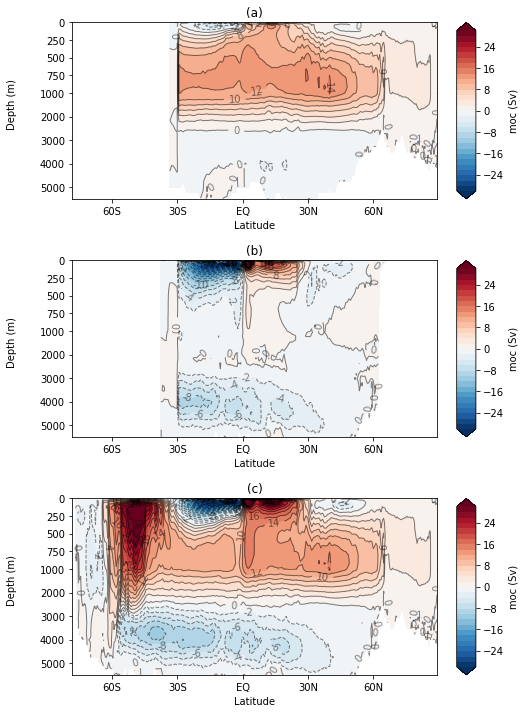

In [10]:
#moc fig
fig = plt.figure(figsize=(8,12))
outer_grid = fig.add_gridspec(3, 2, wspace=0.1, hspace=0.35, width_ratios=[0.95, 0.05], height_ratios=[1,1,1])

cmap = plt.cm.RdBu_r
cmap.set_bad(cfeature.COLORS['land'])
levels = np.arange(-30,31,2)


axt, axm, axc = pltm.inner_gs_vardepth(outer_grid[0], labely=True, labelx=True)
for ax in [axt, axm]:
    cb  = ax.contourf(moc.lat, moc.lev, mocm.sel(basin=0), cmap=cmap, levels=levels, extend='both')
    cntr = ax.contour(moc.lat, moc.lev, mocm.sel(basin=0), levels=levels, colors='k', linewidths=1, alpha=0.5)
    ax.clabel(cntr,fmt='%1.0f')
plt.colorbar(cb, cax=axc, extend='both', label =r'moc (Sv)')
axt.set_title('(a)')

axt, axm, axc = pltm.inner_gs_vardepth(outer_grid[2], labely=True, labelx=True)
for ax in [axt, axm]:
    cb  = ax.contourf(moc.lat, moc.lev, mocm.sel(basin=1), cmap=cmap, levels=levels, extend='both')
    cntr = ax.contour(moc.lat, moc.lev, mocm.sel(basin=1), levels=levels, colors='k', linewidths=1, alpha=0.5)
    ax.clabel(cntr,fmt='%1.0f')
plt.colorbar(cb, cax=axc, extend='both', label=r'moc (Sv)')
axt.set_title('(b)')
 
axt, axm, axc = pltm.inner_gs_vardepth(outer_grid[4], labely=True,labelx=True)
for ax in [axt, axm]:
    cb  = ax.contourf(moc.lat, moc.lev, mocm.sel(basin=2), cmap=cmap, levels=levels, extend='both')
    cntr = ax.contour(moc.lat, moc.lev, mocm.sel(basin=2), levels=levels, colors='k', linewidths=1, alpha=0.5)
    ax.clabel(cntr,fmt='%1.0f')
plt.colorbar(cb, cax=axc, extend='both', label=r'moc (Sv)')
axt.set_title('(c)')

fig.savefig('plots/fig-17_ocean_moc.png', bbox_inches='tight')
fig.savefig('plots/fig-17_ocean_moc.pdf', bbox_inches='tight')

In [ ]:
#moc fig old

fig = plt.figure(figsize=(6,12))
outer_grid = fig.add_gridspec(3, 2, wspace=0.1, hspace=0.25, width_ratios=[0.95, 0.05], height_ratios=[1,1,1])

axt = plt.subplot(outer_grid[0,0])
axm = plt.subplot(outer_grid[1,0], sharex=axt, sharey=axt)
axb = plt.subplot(outer_grid[2,0], sharex=axt, sharey=axt)
axc = plt.subplot(outer_grid[2,1])

levels= np.arange(-16,17,2)
vmin=-30
vmax=30

class nf(float):
    def __repr__(self):
        str = '%.0f' % (self.__float__(),)
        return '%.0f' % self.__float__()
    
# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r'
else:
    fmt = '%r'
    
axt.pcolormesh(moc.lat, moc.lev, mocm.sel(basin=0), cmap='RdBu_r', vmin=vmin, vmax=vmax)
CS=axt.contour(moc.lat, moc.lev, mocm.sel(basin=0), colors='k', levels=levels)
CS.levels = [nf(val) for val in CS.levels]
ax.clabel(CS, CS.levels, inline=True, fontsize=10, fmt=fmt)

axm.pcolormesh(moc.lat, moc.lev, mocm.sel(basin=1), cmap='RdBu_r', vmin=vmin, vmax=vmax)
CS=axm.contour(moc.lat, moc.lev, mocm.sel(basin=1), colors='k', levels=levels)
CS.levels = [nf(val) for val in CS.levels]
ax.clabel(CS, CS.levels, inline=True, fontsize=10, fmt=fmt)

cb = axb.pcolormesh(moc.lat, moc.lev, mocm.sel(basin=2), cmap='RdBu_r', vmin=vmin, vmax=vmax)
CS=axb.contour(moc.lat, moc.lev, mocm.sel(basin=2), colors='k', levels=levels)
plt.colorbar(cb, cax=axc, orientation='vertical', label='Sv', pad=0.1)
CS.levels = [nf(val) for val in CS.levels]
ax.clabel(CS, CS.levels, inline=True, fontsize=10, fmt=fmt)

axt.invert_yaxis()
labels=['a) Atlantic', 'b) Pacific', 'c) Global']
for i,ax in enumerate([axt, axm, axb]):
    ax.set_title(labels[i])
    ax.set_ylabel('Depth (m)')

axt.xaxis.set_tick_params(labelbottom=False, bottom=True)
axm.xaxis.set_tick_params(labelbottom=False, bottom=True)
    
axb.set_xlabel('Latitude ($^{\circ}$)')
fig.savefig('plots/fig-X17_ocean_moc.png', bbox_inches='tight')